In [2]:
# basics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import random
from functools import partial
import networkx as nx
import re
# penny
import pennylane as qml
from pennylane.transforms import *
from pennylane.math import fidelity_statevector as fidelity_penny
# qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity as fidelity_qiskit
from math import pi
import copy
# self-developed
from transpilation_util import summary_penny, extract_info_from_qnode
from penny_to_graph import Penny_to_Graph


In [3]:
[ds] = qml.data.load("ketgpt")

In [4]:
random.seed(42)
# seed = random.randint(0,1000)
seed = 0

@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

print(summary_penny(circuit))

               0
num_qubit     13
num_gate     205
num_1q_gate  116
num_2q_gate   25
unitary       64
depth         72
None


In [5]:
print(ds.circuits[0][0])
type(ds.circuits[0][0])

H(0)


pennylane.ops.qubit.non_parametric_ops.Hadamard

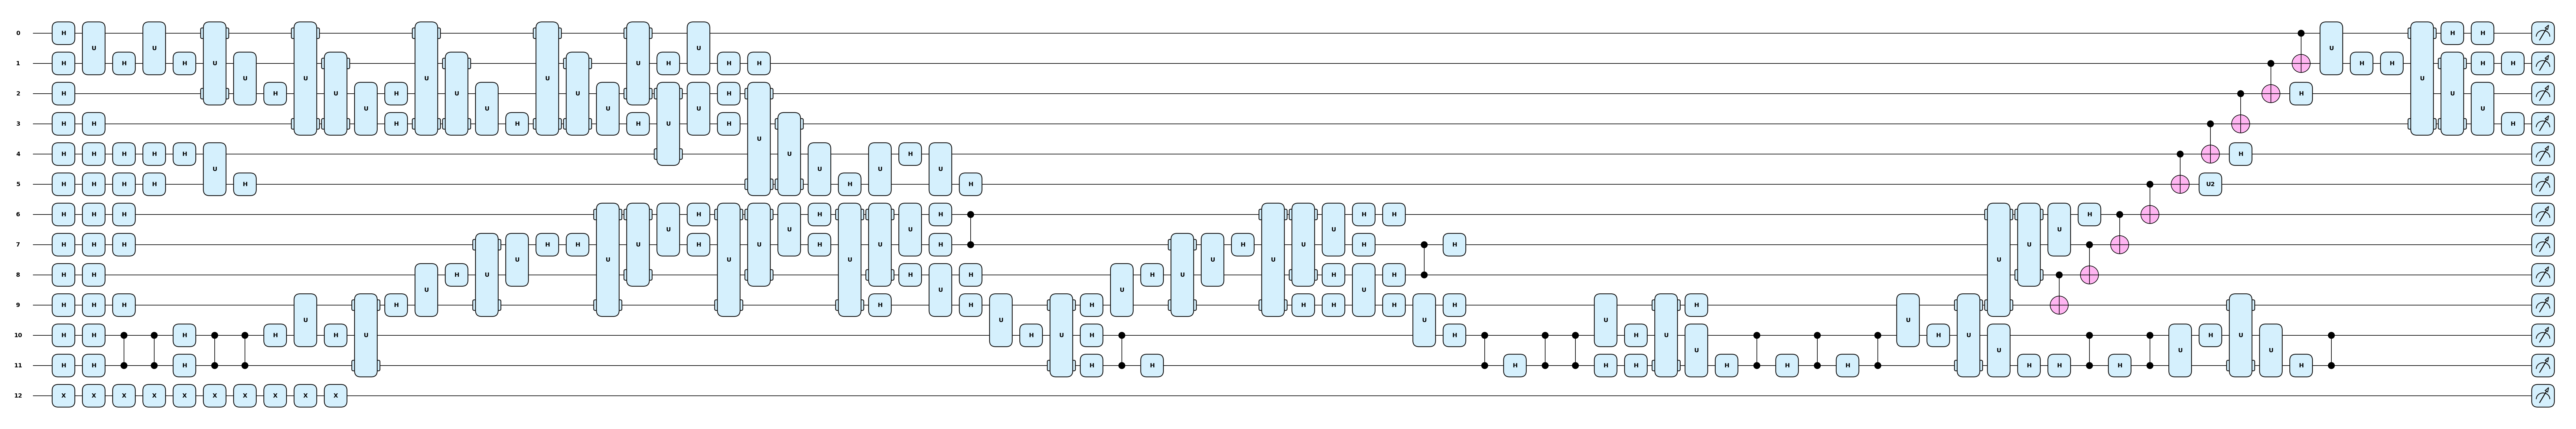

In [6]:
fig, axs = qml.draw_mpl(circuit, style='pennylane')()
plt.show()

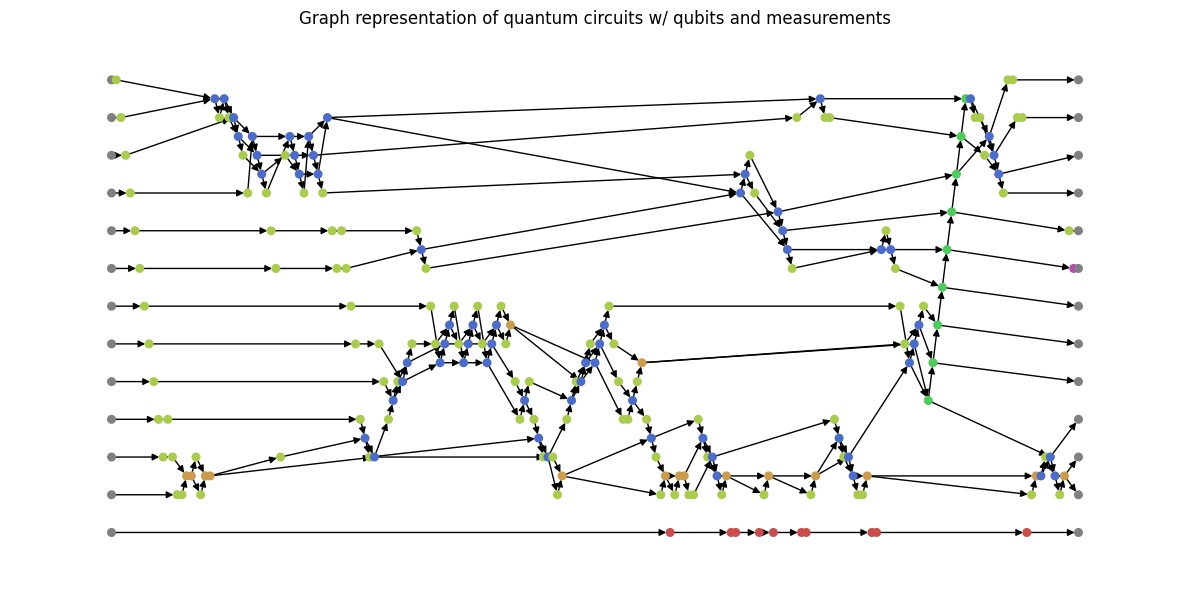

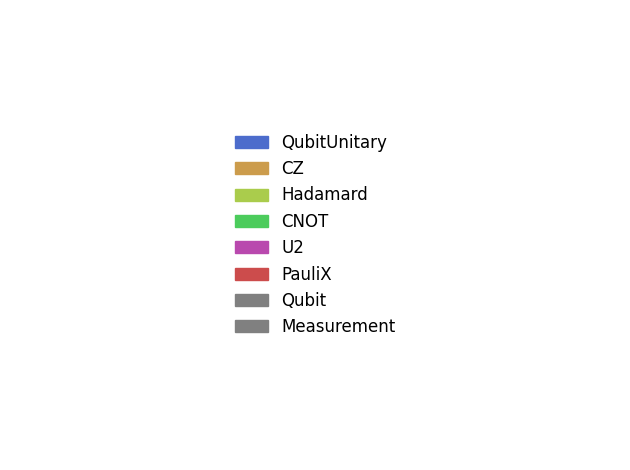

In [7]:
my_pg = Penny_to_Graph(circuit)
G_aug = my_pg.G_aug
G = my_pg.G
# my_pg.show_graph()
my_pg.show_aug_graph()
my_pg.show_legend()

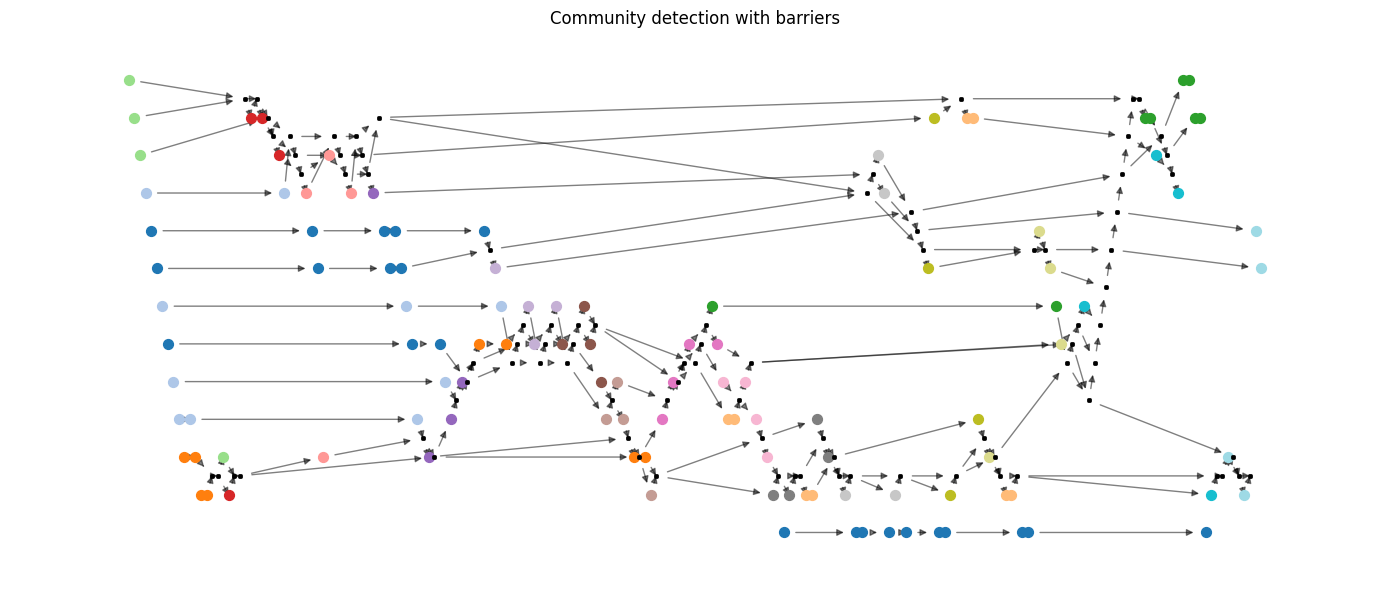

In [29]:
node_arr = list(G.nodes())

# Define barrier nodes
barrier_nodes = [node for node in node_arr 
                   if node.startswith('QubitUnitary') | node.startswith('CNOT') | node.startswith('CZ')]


# Create a copy for community detection
G_community = G.copy()
G_community.remove_nodes_from(barrier_nodes)

# Detect communities
communities = nx.community.greedy_modularity_communities(G_community)

# Convert to list of sets
community_list = [set(c) for c in communities]

# Assign colors to communities
color_map = {}
num_communities = len(community_list)
cmap = plt.get_cmap('tab20', num_communities + 1)  # +1 for barrier color

# Assign community colors
for i, community in enumerate(community_list):
    for node in community:
        color_map[node] = cmap(i)

# Assign same color to all barrier nodes (last color in colormap)
barrier_color = 'black'
for node in barrier_nodes:
    color_map[node] = barrier_color

# Draw the graph
# pos = nx.spring_layout(G, seed=42)
pos = my_pg.pos

plt.figure(figsize=(14, 6))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw nodes by community
for i, community in enumerate(community_list):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(community),
        node_color=[cmap(i)],
        label=f"Community {i+1}",
        node_size=50,
        # edgecolors='black'
    )

# Draw barrier nodes with same color and thicker border
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=barrier_nodes,
    node_color='black',
    label="Barrier Nodes",
    node_size=1,
    linewidths=2,
    node_shape='s'  # square shape for visual distinction
)

plt.title("Community detection with barriers")
plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
# Assign community index to each node in G
for i, community in enumerate(communities):
    for node in community:
        G.nodes[node]['community'] = i

In [130]:
# Step 1: Identify barrier nodes
# barriers = [node for node in G.nodes if 'QubitUnitary' in node]
# barriers.extend([node for node in G.nodes if 'CNOT' in node])
# barriers.extend([node for node in G.nodes if 'CZ' in node])
# barriers = [node for node in G.nodes if any(gate in node for gate in ['QubitUnitary', 'CNOT', 'CZ'])]

# # Step 2: Create subgraph excluding barriers
# G_sub = G.subgraph([node for node in G.nodes if node not in barriers])

# Step 1: Identify barrier nodes
barriers = [node for node in G.nodes if any(gate in node for gate in ['QubitUnitary', 'CNOT', 'CZ'])]

# Step 2: Create subgraph excluding barriers
barrier_set = set(barriers)
G_sub = G.subgraph([node for node in G.nodes if node not in barrier_set])


# Step 3: Apply community detection
communities = list(nx.community.greedy_modularity_communities(G_sub))

# Step 4: Add each barrier as its own singleton community
for barrier in barriers:
    communities.append({barrier})

# Step 5: Create a mapping from node to original community index
node_to_original_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_original_community[node] = i

# Step 6: Extract numeric index from node names
def extract_index(name):
    match = re.search(r'_(\d+)$', name)
    return int(match.group(1)) if match else None

# Step 7: Sort nodes by numeric index
sorted_nodes = sorted(G.nodes(), key=extract_index)

# Step 8: Reindex communities based on first appearance in sorted node list
original_to_new_index = {}
new_index = 0
node_to_reindexed_community = {}

for node in sorted_nodes:
    original = node_to_original_community[node]
    if original not in original_to_new_index:
        original_to_new_index[original] = new_index
        new_index += 1
    node_to_reindexed_community[node] = original_to_new_index[original]

# Step 9: Assign reindexed community index to each node in G
for node in G.nodes:
    G.nodes[node]['community'] = node_to_reindexed_community[node]

for node in sorted_nodes[:5]:
    print(f"{node}: Community {G.nodes[node]['community']}")

Hadamard_0: Community 0
Hadamard_1: Community 1
Hadamard_2: Community 2
Hadamard_3: Community 3
Hadamard_4: Community 4


In [131]:
G.nodes['Hadamard_0']

{'type': 'gate',
 'label': 'Hadamard',
 'params': [],
 'wires': [0],
 'community': 0}

In [132]:
# method from my previous work (unitary_sysnthesis_1)
def wire_range(gate_list):
    wires = []
    for gate in gate_list:
        if hasattr(gate, 'wires'):
            wires.extend(gate.wires)
        elif hasattr(gate, 'wire'):
            wires.append(gate.wire)
        elif isinstance(gate, tuple) or isinstance(gate, list):
            # fallback for custom gate representations
            for item in gate:
                if hasattr(item, 'wires'):
                    wires.extend(item.wires)
                elif hasattr(item, 'wire'):
                    wires.append(item.wire)
        elif hasattr(gate, '__str__'):
            # fallback for string-like gates like H(0)
            match = re.findall(r'\((\d+)\)', str(gate))
            wires.extend([int(m) for m in match])
    return [min(wires), max(wires)]

def calculate_effective_u(subcircuit):
    """takes a subcircuit as input and returns an effective unitary"""
    [w_min, w_max] = wire_range(subcircuit)

    # if w_min == w_max: # for 1q gates, return them as they are
    #     return np.array(subcircuit), np.array([w_max])

    wires = np.arange(w_min, w_max+1,1)
    num_eq = w_max - w_min + 1
    initial_matrix = np.diag(np.ones(np.power(2,num_eq)))

    # effective unitary
    dev = qml.device('default.qubit', wires=wires)
    @qml.qnode(dev)
    def internal_circuit(idx):
        qml.StatePrep(initial_matrix[idx], wires=wires)
        for j in subcircuit:
            qml.apply(j)
        return qml.state()
    
    effective_u = []
    for idx in range(np.power(2,num_eq)):
        effective_u.append(internal_circuit(idx))
    effective_u = np.stack(effective_u, axis=1)
    
    return effective_u, wires

def subcircuit_syntehsis(G, ds, communities, seed=0):
    num_community = len(communities)
    # idx
    subcircuit_idx_arr = []
    for i in range(num_community):
        temp_gate = [n for n in G.nodes if G.nodes[n].get('community') == i]
        temp_com_label = [int(g.split('_')[1]) for g in temp_gate]
        subcircuit_idx_arr.append(temp_com_label)

    # gate list
    subcircuit_gate_arr = []
    for i in range(num_community):
        subcircuit_gate_arr.append([ds.circuits[seed][j] for j in subcircuit_idx_arr[i]])

    u_arr = []
    wire_arr = []
    for i in range(num_community):
        u_temp, w_temp = calculate_effective_u(subcircuit_gate_arr[i])
        u_arr.append(u_temp)
        wire_arr.append(w_temp)

    effective_u_dic = {}
    effective_u_dic['u'] = u_arr
    effective_u_dic['wires'] = wire_arr

    return effective_u_dic

In [133]:
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed=0)
num_gate = len(effective_u_dic['u'])

dev = qml.device('default.qubit')

# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@qml.qnode(dev)
def decompose_combined_u():
    for i in range(num_gate):
        qml.QubitUnitary(effective_u_dic['u'][i], wires=effective_u_dic['wires'][i])
    return qml.state()

print(summary_penny(decompose_combined_u))

               0
num_qubit     13
num_gate     170
num_1q_gate   81
num_2q_gate    0
unitary      170
depth         79
None


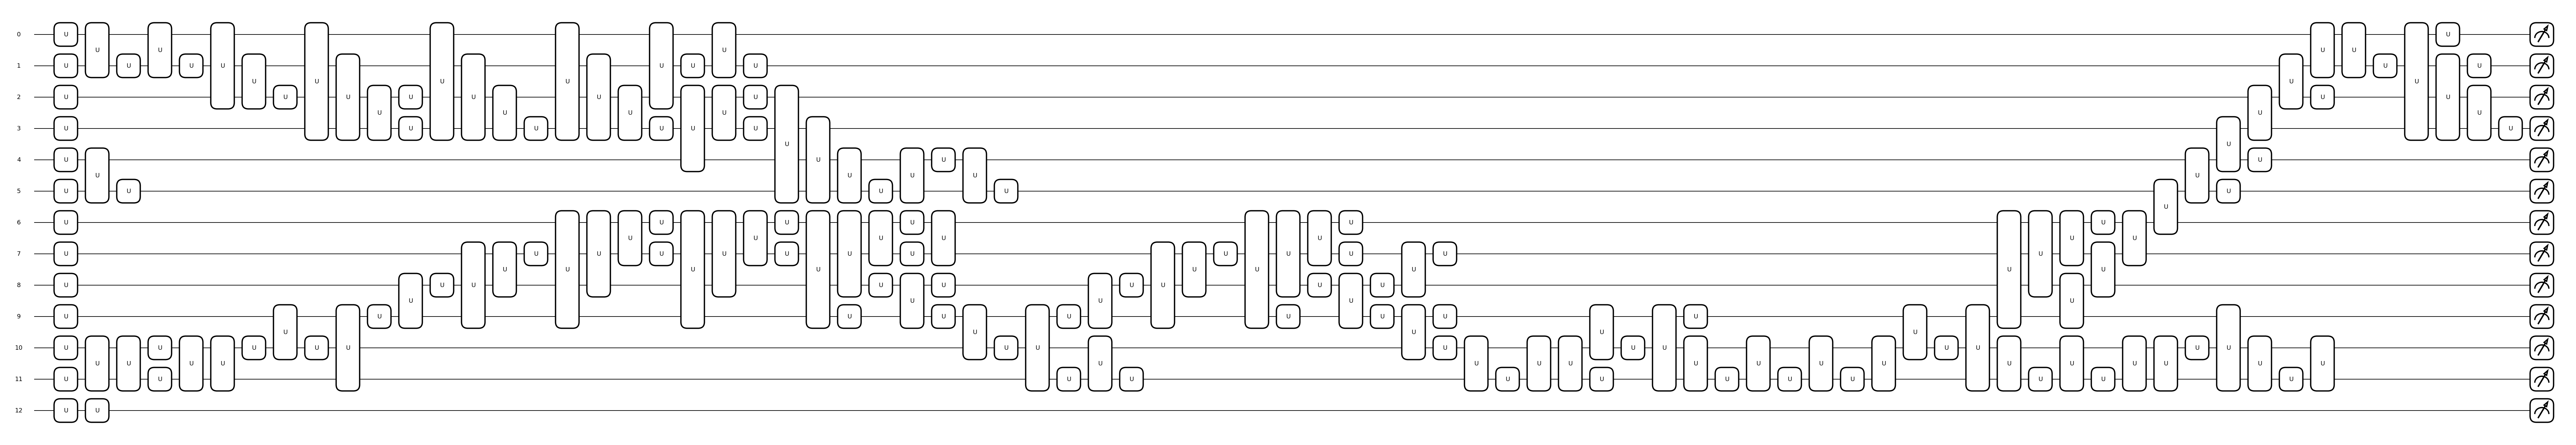

In [134]:
qml.draw_mpl(decompose_combined_u)()
plt.show()

In [222]:
idx = 20
print('u : ', effective_u_dic['u'][idx])
print('wires : ', effective_u_dic['wires'][idx])
print('dim : ', effective_u_dic['wires'][idx].shape[0])

u :  [[1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 6.123234e-17-1.j]]
wires :  [0 1]
dim :  2


In [225]:
def is_identity(gate):
    # multiple = gate[0][0]
    return np.allclose(gate, np.eye(gate.shape[0]))

def is_hadamard(gate):
    h = np.array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]]).real
    return np.allclose(gate, h)

def is_x(gate):
    x = np.array([[0,1], [1,0]])
    return np.allclose(gate, x)

def is_cnot(gate):
    cnot = np.array([[1,0,0,0],
                     [0,1,0,0],
                     [0,0,0,1],
                     [0,0,1,0]])
    return np.array_equal(gate.real, cnot)

def is_cz(gate):
    cz = np.diag([1,1,1,-1])
    return np.array_equal(gate.real, cz)

In [ ]:
effective_u_dic = subcircuit_syntehsis(G, ds, communities, seed=0)
num_gate = len(effective_u_dic['u'])

dev = qml.device('default.qubit')

# @partial(decompose, gate_set={qml.CZ, qml.CNOT, qml.RZ, qml.RY, qml.RX, qml.SX, qml.PauliX})
@cancel_inverses
@qml.qnode(dev)
def decompose_combined_u():
    for i in range(num_gate):
        params = effective_u_dic['u'][i]
        wires = effective_u_dic['wires'][i]
        dim = wires.shape[0]
        if is_identity(params):
            continue
        elif dim == 1:
            if is_hadamard(params):
                qml.Hadamard(wires[0])
            if is_x(params):
                qml.PauliX(wires[0])
        elif dim == 2:
            if is_cnot(params):
                qml.CNOT(wires)
            if is_cz(params):
                qml.CZ(wires)
        else:
            qml.QubitUnitary(params, wires=wires)
    return qml.state()

print(summary_penny(decompose_combined_u))

              0
num_qubit    12
num_gate     98
num_1q_gate  49
num_2q_gate  19
unitary      30
depth        40
None


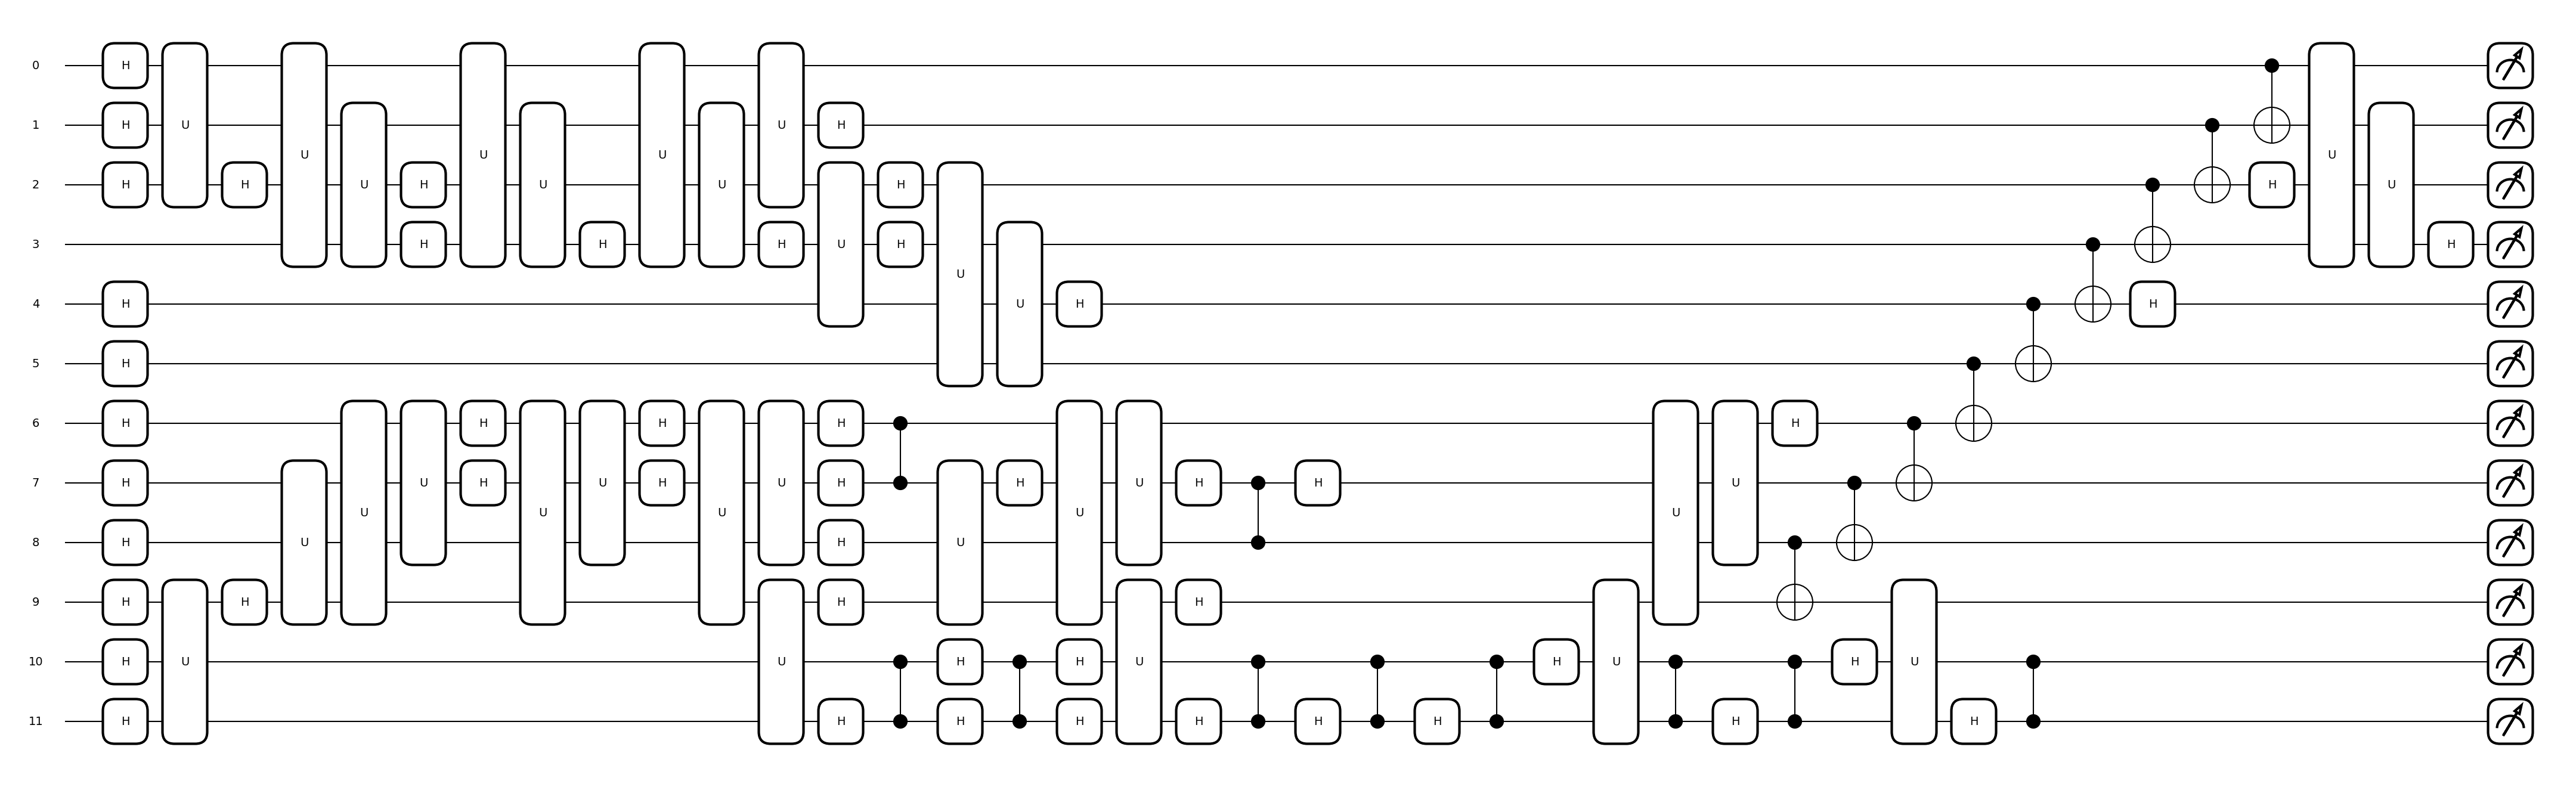

In [229]:
qml.draw_mpl(decompose_combined_u)()
plt.show()

In [235]:
circuit_info = extract_info_from_qnode(decompose_combined_u)

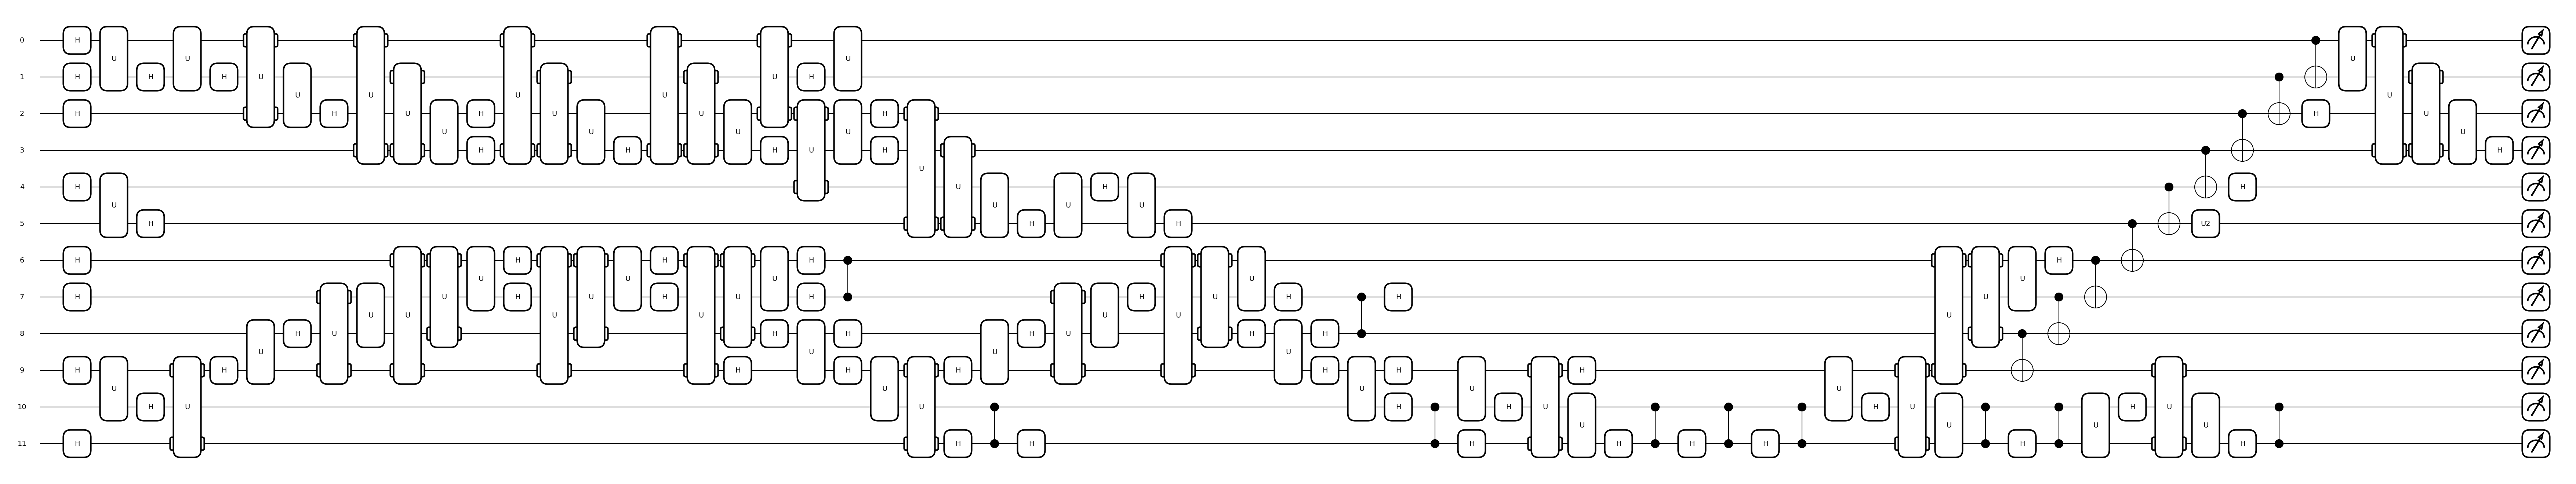

               0
num_qubit     12
num_gate     145
num_1q_gate   62
num_2q_gate   19
unitary       64
depth         59
None


In [234]:
@compile
@compile
@qml.qnode(qml.device('default.qubit'))
def circuit(): # 0 to 99
    for op in ds.circuits[seed]:
        qml.apply(op)
    return qml.state()

qml.draw_mpl(circuit)()
plt.show()

print(summary_penny(circuit))

To Qiskit

In [23]:
def to_qiskit(qc, dict_elem): # pennylane to qiskit using the dictionary to map
    name = dict_elem['name']
    wires = dict_elem['wires']
    params = dict_elem['params']

    gate_map = {
        'Hadamard': lambda : qc.h(wires[0]),
        'PauliX': lambda: qc.x(wires[0]),
        'CNOT': lambda: qc.cx(wires[0], wires[1]),
        'CZ': lambda: qc.cz(wires[0], wires[1]),
        'RY': lambda: qc.ry(params[0], wires[0]),
        'QubitUnitary': lambda: qc.append(UnitaryGate(params[0]), wires),
        'U1': lambda: qc.p(params[0], wires[0]),
        'U2': lambda: qc.u(pi/2, params[0], params[1], wires[0])
    }

    if name in gate_map:
        gate_map[name]()
    else:
        raise ValueError(f"Unsupported gate: {name}")

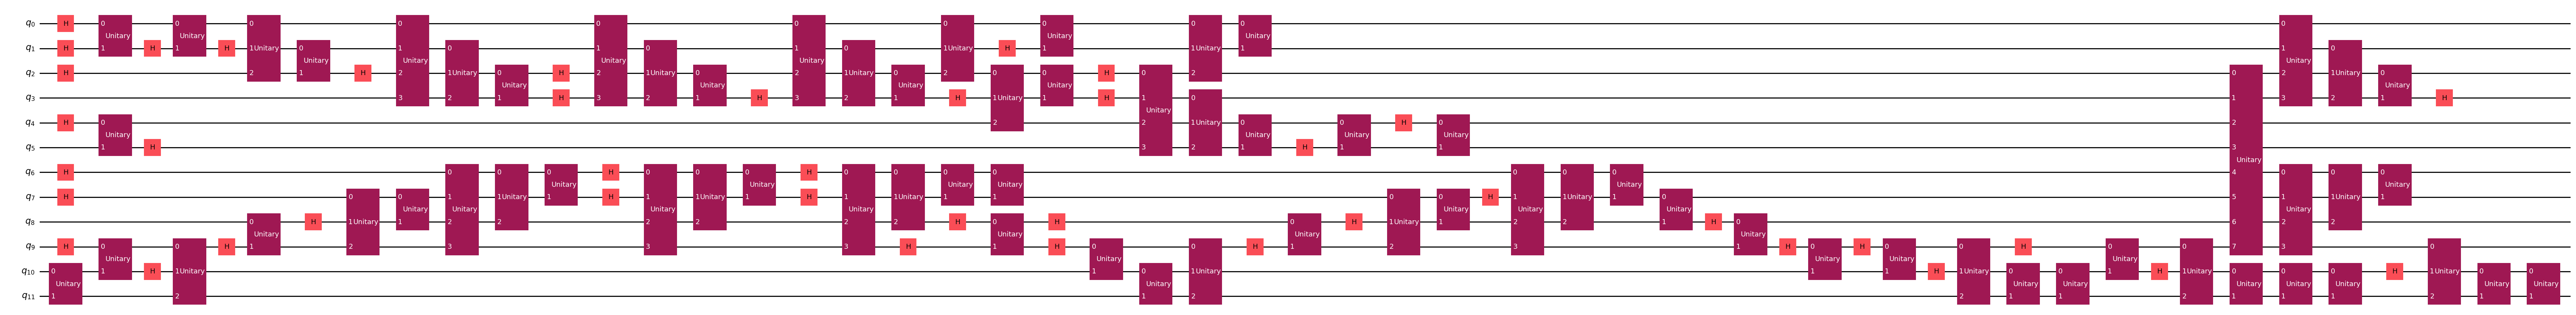

In [32]:
num_q = qml.specs(decompose_combined_u)()['resources'].num_wires
circuit_info = extract_info_from_qnode(decompose_combined_u)
qc = QuantumCircuit(num_q)
for dict_elem in circuit_info:
    to_qiskit(qc, dict_elem)
circuit_drawer(qc, output='mpl', fold=-1)

In [33]:
from qiskit.transpiler.passes.synthesis import UnitarySynthesis
from qiskit.transpiler import PassManager

# unitary synthesis
basis = ['cz', 'cx', 'rz', 'sx', 'x']
synth_pass = UnitarySynthesis(basis_gates=basis)
pm = PassManager(synth_pass)
optimized_circuit = pm.run(qc)
circuit_drawer(optimized_circuit, output='mpl')  

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000160816339A0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 2228x3843385 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2228x3843385 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2228.58x3.84339e+06 with 1 Axes>